# Predicting Customer Churn
For an entreprise, retaining a customer is cheaper than finding a new one, thus having a better understanding on why people churn and what variables make them more likely to leave is vital for the success of a company

### Objective
The purpose of this project is to predict customer churn based on different explanatory variables such as consumed services and demographics.

### Performance
To do so, a classification model will be built and tuned in order to minimise the error of prediction. The performance will be measured by:
* accuracy: % of good estimations 
* recall: % of positives outcomes correctly identified (TP / (TP+FN) )
* precision: % of positive predictions that are actually correct (TP / (TP+FP) )
* f1-score: harmonic mean of precision and recall

For this task, the most important is to identify as much customers likely to leave the company as possible, i.e. have a good recall. However, if all customers were identified like likely to leave, recall would be very high but precision would probably be very low as there would be many false positives. For this reason, it is important to get a high recall, but also a high precision (and therefore, a good f1-score). 

===================================================================================================

# Complete Pipeline
===================================================================================================

In [1]:
# to handle datasets & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()

# from sklearn
from sklearn.preprocessing import RobustScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# For dealing with imbalanced data
from imblearn.over_sampling import SMOTE

# from feature_engine
from feature_engine.encoding import OneHotEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer
from feature_engine.selection import DropCorrelatedFeatures
from feature_engine.outliers import Winsorizer

# for modelling
from sklearn.ensemble import ExtraTreesClassifier
import pickle

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, \
                            f1_score, precision_score, recall_score, roc_curve, roc_auc_score

# For interpretation
import lime.lime_tabular


# Pandas display
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.3f}'.format

# Load & prepare data

In [2]:
data_dict = raw_data = pd.read_excel('E Commerce Dataset.xlsx', sheet_name = 0)
raw_data = pd.read_excel('E Commerce Dataset.xlsx', sheet_name = 1)
raw_data.head(3)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.000,Mobile Phone,3,6.000,Debit Card,Female,3.000,3,Laptop & Accessory,2,Single,9,1,11.000,1.000,1.000,5.000,159.930
1,50002,1,NaN,Phone,1,8.000,UPI,Male,3.000,4,Mobile,3,Single,7,1,15.000,0.000,1.000,0.000,120.900
2,50003,1,NaN,Phone,1,30.000,Debit Card,Male,2.000,4,Mobile,3,Single,6,1,14.000,0.000,1.000,3.000,120.280


In [3]:
#Remove first column = ID 
data = raw_data.iloc[:,1:] 

# Splitting into train & test sets to avoid data leakage
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 42) 

In [4]:
print(f'The train set contains {train_set.shape[0]} rows and {train_set.shape[1]} columns.')
print(f'The test set contains {test_set.shape[0]} rows and {test_set.shape[1]} columns.')

The train set contains 4504 rows and 19 columns.
The test set contains 1126 rows and 19 columns.


In [5]:
# Separating target from features
X_train, X_test = train_set.drop(['Churn'], axis=1), test_set.drop(['Churn'], axis=1) # predictive variables
y_train, y_test = train_set[['Churn']], test_set[['Churn']] # target

X_train.shape, y_train.shape

((4504, 18), (4504, 1))

# Configuration

In [6]:
def confusion_plot(y_pred, y_true):
    # Getting the data
    tn, fp, fn, tp = confusion_matrix(y_true = y_true, y_pred = y_pred).ravel()
    cm = [tp, fn, fp, tn]
    data = np.asarray(cm).reshape(2,2)
   
    # Annotation inside heatmap
    group_names = ['True Pos','False Neg\nType II Error','False Pos\nType I Error','True Neg']
    group_counts = ['{0:0.0f}'.format(value) for value in cm]
    group_percentages = ['{0:.2%}'.format(value) for value in cm/np.sum(cm)]
   
    labels = [f'{v1}\n{v2}\n\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Color
    cmap = sns.color_palette("Blues", as_cmap=True)
    
    # Plot
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(data, annot=labels, annot_kws={"fontsize":13}, fmt='', 
                xticklabels='10', yticklabels='10', cmap=cmap) 
   
    
    ax.set_title('Confusion Matrix\n', weight = 'bold', size = 20)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel('Predicted', size = 15)
    ax.set_ylabel('Actual', size = 15 )
    plt.show()
    
    
    recall = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    error_rate = (fp+fn)/(fp+fn+tp+tn) 

    print('Sensitivity/Recall: {:.2%} ---% of "1s" correctly predicted'.format(recall))
    print('         Precision: {:.2%} ---% of correctly predicted "1s" out of total predicted "1s"'.format(precision))    
    print('       Specificity: {:.2%} ---% of "0s" correctly predicted'.format(specificity))
    print('          Accuracy: {:.2%} ---% of true pos/neg overall'.format(1-error_rate))    

In [7]:
def ROC_plot(y_test, y_pred):
    # fpr = false positive rates
    # tpr = true positive rates
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    plt.figure(figsize = (8,5))
    plt.title('ROC Curve',  weight = 'bold', size = 20)
    plt.plot(fpr, tpr, 'r')
    plt.plot([0,1],[0,1], 'k', linestyle='--')
    plt.text(0.6,0.1,'Area Under Curve: {:.2f}'.format(auc), bbox=dict(facecolor='w', edgecolor = 'k', alpha=0.5))
    plt.xlabel('False positives [%]', weight = 'bold')
    plt.ylabel('True positives [%]', weight = 'bold')
    plt.show()   

## Features

In [8]:
# identify numerical features
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']

# identify numerical features
num_vars = [var for var in X_train.columns if X_train[var].dtype != 'O']

# identify num features with missing values
num_vars_nan = [var for var in num_vars if X_train[var].isnull().sum() > 0]

# Getting strictly positive and continuous variables
log_vars = [var for var in num_vars if X_train[var].isin([0]).sum() == 0]

# Pipeline

In [9]:
feature_engineering_pipeline = Pipeline([   
    # ==== HANDLE MISSING VALUES ====
    # add missing indicator & impute "mean" to numerical varaibles 
     ('missing_indicator', AddMissingIndicator(variables=num_vars_nan)),
    
     ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=num_vars_nan)),
    
    
    # ==== APPLY WINSORIZATION TO HANDLE OUTLIERS ====
    ('outliers', Winsorizer(capping_method = 'gaussian',  variables = log_vars)),
    

    # ==== APPLY LOG TRANSFORMATION TO NUM VARIABLES ====
     # log transformation
     ('log', LogTransformer(variables=log_vars)),
    

    # ==== ENCODING CATEGORICAL VARIABLES ====
     # Applying one-hot encoder
     ('one_hot_encoder', OneHotEncoder()),
    
    
    # Dropping new features with too much correlation
    ('dropping_high_corr', DropCorrelatedFeatures(method = 'spearman', threshold = 0.99))
    
])    

In [10]:
feature_engineering_pipeline.fit(X_train)

Pipeline(steps=[('missing_indicator',
                 AddMissingIndicator(variables=['Tenure', 'WarehouseToHome',
                                                'HourSpendOnApp',
                                                'OrderAmountHikeFromlastYear',
                                                'CouponUsed', 'OrderCount',
                                                'DaySinceLastOrder'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Tenure', 'WarehouseToHome',
                                              'HourSpendOnApp',
                                              'OrderAmountHikeFromlastYear',
                                              'CouponUsed'...
                                       'SatisfactionScore', 'NumberOfAddress',
                                       'OrderAmountHikeFromlastYear',
                                       'OrderCount'])),
            

In [11]:
## Transform datasets & get feature names
X_train = feature_engineering_pipeline.transform(X_train)
feat_names = X_train.columns

X_test = feature_engineering_pipeline.transform(X_test)

### Applying scaler

In [12]:
# Adding scaler
scaler = RobustScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Applying SMOTE to training data

In [13]:
print('tot obs:', y_train.shape[0])
y_train.value_counts()

tot obs: 4504


Churn
0        3741
1         763
dtype: int64

In [14]:
sm = SMOTE(k_neighbors = 7, random_state = 42)

# Fit the model to generate the data.
X_train, y_train = sm.fit_resample(X_train, y_train)
y_train.value_counts()

Churn
0        3741
1        3741
dtype: int64

In [15]:
X_train.shape, y_train.shape

((7482, 40), (7482, 1))

## Modelling on test set

In [16]:
y_train = y_train.values.ravel()

In [17]:
model = pickle.load(open('vot_clf.pkl', 'rb'))

model.fit(X_train, y_train) 

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(leaf_size=15, n_jobs=-1,
                                                   n_neighbors=2,
                                                   weights='distance')),
                             ('svc',
                              SVC(C=2.5, class_weight='balanced', degree=2,
                                  probability=True)),
                             ('extra_trees',
                              ExtraTreesClassifier(bootstrap=True, max_depth=29,
                                                   max_features=6,
                                                   max_samples=1.0,
                                                   min_samples_split=3,
                                                   n_estimators=500, n_jobs=-1,
                                                   random_state=42)),
                             ('xgbo...
                                            max_delta_step=

#### Training set performance

In [18]:
# Getting predicted values
y_pred = model.predict(X_train)

# Getting metrics
accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)

In [19]:
# determine metrics
print('train accuracy:', round(accuracy, 3))
print('train f1:',  round(f1, 3))
print('train precision:', round(precision, 3))
print('train recall:', round(recall, 3))

train accuracy: 1.0
train f1: 1.0
train precision: 1.0
train recall: 1.0


#### Test set performance

In [20]:
# Getting predicted values
y_pred = model.predict(X_test)

# Getting metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [21]:
# determine metrics
print('test accuracy:', round(accuracy, 3))
print('test f1:',  round(f1, 3))
print('test precision:', round(precision, 3))
print('test recall:', round(recall, 3))

test accuracy: 0.981
test f1: 0.942
test precision: 0.971
test recall: 0.914


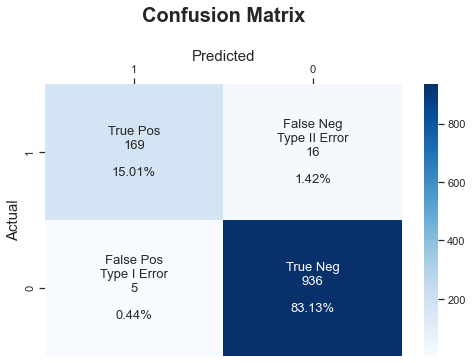

Sensitivity/Recall: 91.35% ---% of "1s" correctly predicted
         Precision: 97.13% ---% of correctly predicted "1s" out of total predicted "1s"
       Specificity: 99.47% ---% of "0s" correctly predicted
          Accuracy: 98.13% ---% of true pos/neg overall


In [22]:
confusion_plot(y_pred = y_pred, y_true = y_test)

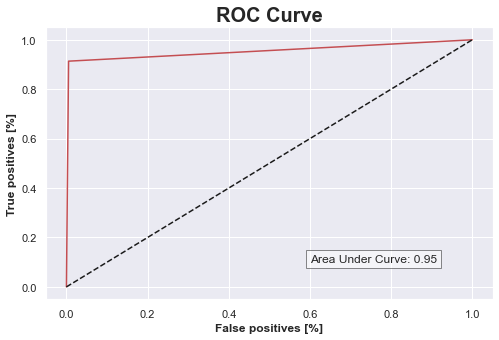

In [23]:
ROC_plot(y_test, y_pred)

## Measuring performance of the best individual model

In [38]:
# From hyperparameter fine tuning with 10-fold CV
best_params = {'max_depth': 29,
                 'max_features': 6,
                 'max_samples': 1.0,
                 'min_samples_leaf': 1,
                 'min_samples_split': 3,
                 'n_estimators': 500}

model = ExtraTreesClassifier(random_state = 42, n_jobs = -1, bootstrap  = True, **best_params)

model.fit(X_train, y_train) 

ExtraTreesClassifier(bootstrap=True, max_depth=29, max_features=6,
                     max_samples=1.0, min_samples_split=3, n_estimators=500,
                     n_jobs=-1, random_state=42)

In [39]:
# Getting predicted values
y_pred = model.predict(X_test)

# Getting metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# determine metrics
print('test accuracy:', round(accuracy, 4))
print('test f1:',  round(f1, 4))
print('test precision:', round(precision, 4))
print('test recall:', round(recall, 4))

test accuracy: 0.9663
test f1: 0.8889
test precision: 0.9682
test recall: 0.8216


The Voting Classifier does better than the best individual model.

### Feature Importance

In [24]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test, 
                                                   feature_names=feat_names, 
                                                   verbose=True, mode='classification')

In [25]:
i = 0
exp = explainer.explain_instance(X_test[i], model.predict_proba, num_features=7)
print('Real output:', y_test.reset_index(drop = True).Churn[i])

Intercept 0.273237850289225
Prediction_local [0.45194691]
Right: 0.9764107894740076
Real output: 1


In [26]:
exp.show_in_notebook(show_table=True)

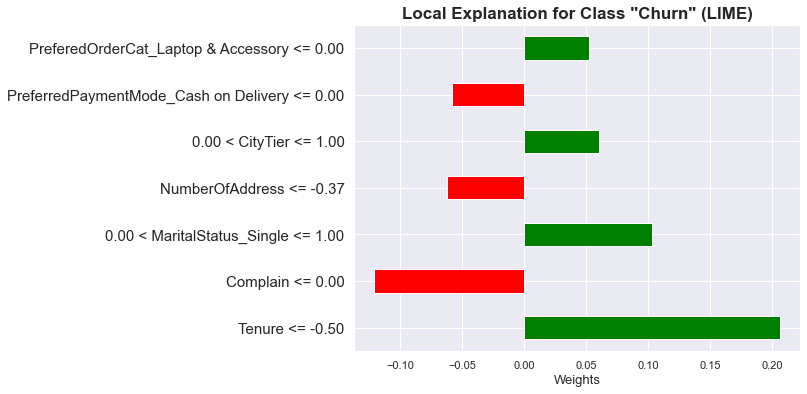

In [27]:
# Getting data
df_pred = pd.DataFrame(exp.as_list()).T
df_pred.columns = df_pred.iloc[0]
df_pred = df_pred.iloc[1]

# Getting colors
colors = ['green' if weight > 0 else 'red' for weight in df_pred.values ]

# Plotting
plt.figure(figsize=(8,6))
df_pred.plot.barh(color = colors)
plt.title('Local Explanation for Class "Churn" (LIME)', weight = 'bold', size = 17)
plt.xlabel('Weights', size = 13)
plt.ylabel('')
plt.yticks(size=15)
plt.show()

In [28]:
i = 1
exp = explainer.explain_instance(X_test[i], model.predict_proba, num_features=7)
print('Real output:', y_test.reset_index(drop = True).Churn[i])

Intercept 0.4335686746338795
Prediction_local [0.16343899]
Right: 0.00576324722632754
Real output: 0


In [29]:
exp.show_in_notebook(show_table=True)

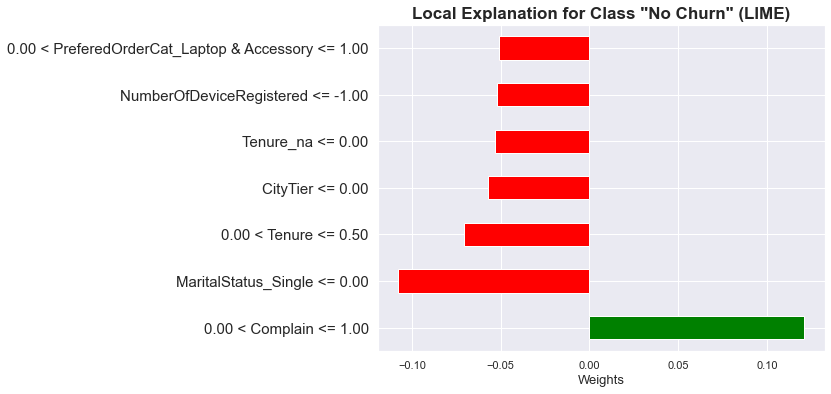

In [30]:
# Getting data
df_pred = pd.DataFrame(exp.as_list()).T
df_pred.columns = df_pred.iloc[0]
df_pred = df_pred.iloc[1]

# Getting colors
colors = ['green' if weight > 0 else 'red' for weight in df_pred.values ]

# Plotting
plt.figure(figsize=(8,6))
df_pred.plot.barh(color = colors)
plt.title('Local Explanation for Class "No Churn" (LIME)', weight = 'bold', size = 17)
plt.xlabel('Weights', size = 13)
plt.ylabel('')
plt.yticks(size=15)
plt.show()